In [2]:
import qiskit
import numpy as np
import tqix
import sys
sys.path.insert(1, '../')
import qtm.base
import qtm.encoding

def create_basic_vector(num_qubits: int):
    """Generate list of basic vectors

    Args:
        num_qubits (int): number of qubits

    Returns:
        np.ndarray: |00...0>, |00...1>, ..., |11...1>
    """
    bs = []
    for i in range(0, 2**num_qubits):
        b = np.zeros((2**num_qubits, 1))
        b[i] = 1
        bs.append(b)
    return bs


def calculate_sigma(U: np.ndarray, b: np.ndarray):
    """Calculate measurement values

    Args:
        U (np.ndarray): operator
        b (np.ndarray): basic vector

    Returns:
        np.ndarray: sigma operator
    """
    return (np.conjugate(np.transpose(U)) @ b @ np.conjugate(np.transpose(b)) @ U)


Step 1. Create $\rho_{unk}$. It's psi


In [3]:
num_qubits = 2
num_observers = 10
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
rho = qiskit.quantum_info.DensityMatrix(psi).data
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
qc.initialize(psi)


Step 2. Create Us = $U_1, U_2, ..., U_{num\_observer}$ and bs = $|0\rangle, |1\rangle, ..., |2^n-1\rangle$.

bs[0] = [1, 0, ... 0], bs[$2^n-1$] = [0, 0, ..., 1]


In [3]:
Us, bs = [], []
for i in range(0, num_observers):
    random_psi = 2*np.random.rand(2**num_qubits)-1
    random_psi = random_psi / np.linalg.norm(random_psi)
    encoder = qtm.encoding.Encoding(random_psi, 'amplitude_encoding')
    qcs = (qc.copy()).compose(encoder.qcircuit)
    U = (qiskit.quantum_info.Operator(encoder.qcircuit).data)
    Us.append(U)
    bs = create_basic_vector(num_qubits)


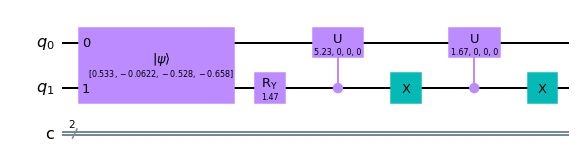

In [10]:
qcs.draw('mpl')

Step 3. Calculate $\sigma_i=\sigma_i^{(0)}, \sigma_i^{(1)}, ..., \sigma_i^{(2^n-1)}$
with $\sigma_i^{(j)}=U_i^{\dagger}|j\rangle\langle j|U_i$


In [4]:
sigmass = []
for i in range(0, num_observers):
    sigmas = []
    for b in bs:
        sigma = calculate_sigma(Us[i], b)
        sigmas.append(sigma)
    sigmass.append(sigmas)

Step 4: Calculate $\mu(\rho_{unk})=\frac{1}{num\_ observer}\sum_{i=1}^{num\_observer}\sum_{b=0}^{2^n-1} \text{Tr}(\sigma_i^{(b)}\rho_{unk})\sigma_i^{(b)}$


In [5]:
def calculate_mu(density_matrix):
    M = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
    for i in range(0, num_observers):
        for j in range(0, 2**num_qubits):
            k = sigmass[i][j]
            M += np.trace(k @ density_matrix) * k
    M /= num_observers
    return M
    
# M = calculate_mu(rho)

Step 5. 1: Calculate $\tilde{\rho}=\frac{1}{num\_ observer}\sum_{i=1}^{num\_observer}(\sum_{b=0}^{2^n-1} (\text{Tr}(\sigma_i^{(b)}\rho_{unk}).\mu^{-1}(\sigma_i^{(b)})))$


In [6]:
rho_hat = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
for i in range(0, num_observers):
    if i % 10 == 0:
        print(i)
    for j in range(0, 2**num_qubits):
        k = sigmass[i][j]
        rho_hat += np.trace(k @ rho)*np.linalg.inv(calculate_mu(k))
rho_hat /= num_observers
new_rho_hat = (np.conjugate(np.transpose(
    rho_hat)) @ rho_hat) / (np.trace(np.conjugate(np.transpose(rho_hat)) @ rho_hat))


0


Step 5.2: Calculate $\tilde{\rho}=\sum_{i=1}^{num\_observer}p_i(\sum_{b=0}^{2^n-1} (\text{Tr}(\sigma_i^{(b)}\rho_{unk}).\mu^{-1}(\sigma_i^{(b)})))$

<img width = '600px' src = '../../images/shadow_tomography3.jpg'>

In [9]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
X = get_truncated_normal(mean= num_observers/2, sd=2, low=0, upp = num_observers).rvs(10000)

# Calculate p_i
probs = np.zeros(num_observers)
for i in range(0, 10000):
    probs[int(X[i])] += 1
probs /= np.sum(probs)


rho_hat = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
for i in range(0, num_observers):
    matrix_tmp = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
    for j in range(0, 2**num_qubits):
        k = sigmass[i][j]
        if i == 1 and j == 1:
            print(calculate_mu(k) @ np.linalg.inv(calculate_mu(k)))
        matrix_tmp += np.trace(k @ rho)*np.linalg.inv(calculate_mu(k))
    rho_hat += probs[i]*matrix_tmp


new_rho_hat = (np.conjugate(np.transpose(
    rho_hat)) @ rho_hat) / (np.trace(np.conjugate(np.transpose(rho_hat)) @ rho_hat))


[[ 1.00000000e+00+0.j  2.27026913e-17+0.j  3.71983215e-17+0.j
  -2.80383594e-17+0.j]
 [ 1.55427331e-17+0.j  1.00000000e+00+0.j  4.87301994e-17+0.j
  -1.00326852e-17+0.j]
 [ 1.42397741e-16+0.j  8.35938394e-17+0.j  1.00000000e+00+0.j
   1.59333294e-17+0.j]
 [-8.66794254e-17+0.j  1.11973080e-16+0.j  4.71160770e-17+0.j
   1.00000000e+00+0.j]]


In [64]:
print("p", rho)
print("p~", new_rho_hat)
fidelity = qtm.base.trace_fidelity(rho, new_rho_hat)
trace = qtm.base.trace_distance(rho, new_rho_hat)
print("Fidelity: ", fidelity)
print("Trace: ", trace)


p [[ 4.15657903e-01+0.j  3.72333733e-01+0.j -6.24958312e-03-0.j
   3.22823396e-01+0.j]
 [ 3.72333733e-01+0.j  3.33525256e-01+0.j -5.59818687e-03-0.j
   2.89175399e-01+0.j]
 [-6.24958312e-03+0.j -5.59818687e-03+0.j  9.39649864e-05+0.j
  -4.85377910e-03+0.j]
 [ 3.22823396e-01+0.j  2.89175399e-01+0.j -4.85377910e-03-0.j
   2.50722876e-01+0.j]]
p~ [[ 0.20131844+0.j -0.14512324+0.j -0.16471181+0.j  0.13737572+0.j]
 [-0.14512324+0.j  0.25186812+0.j  0.13635171+0.j -0.20541471+0.j]
 [-0.16471181+0.j  0.13635171+0.j  0.24156913+0.j -0.17630767+0.j]
 [ 0.13737572+0.j -0.20541471+0.j -0.17630767+0.j  0.30524431+0.j]]
Fidelity:  (0.2775446309809241-1.7208144809154814e-18j)
Trace:  0.9133243744447737


## Materials

<img width = '600px' src = '../../images/shadow_tomography1.jpg'>
<img width = '600px' src = '../../images/shadow_tomography2.jpg'>
